In [1]:
import matplotlib.pyplot as plt
import random as r
import pprint as pp
import numpy as np

In [2]:
# Define type of slice and its parameters
slices_type = {
    'eMBB' : {
        'bandwidth_max': 100000000, #max bandwidth which BS can give to this slice
        'client_weight': 0.3, # Portion of clients which use this type of slice
        'min': 4000000, 
        'max': 800000000 # how much bps can require this type of dlice
      },
      'URLLC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.2,
        'min': 4000000, 
        'max': 800000000
      },
      'MIoT' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.15,
        'min': 4000000, 
        'max': 800000000
      },
      'mMTC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.15,
        'min': 4000000, 
        'max': 800000000
      },
      'voice' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.2,
        'min': 4000000, 
        'max': 800000000
     }
}
          
# Define base station parameters
basestation = {
    'capacity': 20000000000, 
    'coverage': 250,
    'ratios': { # portion of capacity dedicated to various slice type
        'URLLC': 0.01,
        'eMBB': 0.59,
        'mMTC': 0.1,
        'voice': 0.1,
        'MIoT': 0.2
    },
    'x': 300,
    'y': 300
}

# Define mobility patterns and its parameters
mobility_patterns = {
  'car': {
    'distribution': 'normal',
    'params':(0,7),
    'client_weight': 0.10
  },
  'walk': {
    'distribution': 'randint',
    'params': (-1, 1),
    'client_weight': 0.40
  },
  'stationary': {
    'distribution': 'normal',
    'params': (0, 0.1),
    'client_weight': 0.20
  },
  'publictransport': {
    'distribution': 'randint',
    'params': (-4, 4),
    'client_weight': 0.10
  },
  'slackperson':{
    'distribution': 'randint',
    'params':(0, 1),
    'client_weight': 0.20
  }
}

In [3]:
# Define obj Client
class Client:
    def __init__(self, ID, x, y, mobility_pattern, freq, slice_type, bs_capacity, bs, clients_slice = None):
        self.ID = ID
        self.x = x
        self.y = y
        self.mobility_pattern = mobility_pattern
        self.freq = freq
        self.slice_type = slice_type
        self.bs = bs
        self.bs_capacity = bs_capacity
        self.clients_slice = clients_slice
        self.usage_rem = 0
        self.last_usage = 0
        self.connected = False
        
        # stats
        self.tot_connected_time = 0
        self.tot_unconnected_time = 0
        self.tot_requests = 0
        self.consume_time = 0
        self.tot_usage = 0
        
     # for each user we do 4 steps, at each iteration:
     # 1  Connection to BS and start consume
     # 2  Release consume
     # 3  Continue client movement
     
    def step_1(self):
        if self.bs is not None:
            if self.usage_rem > 0:
                if self.connected:
                    self.start_consume()
                else:
                    self.connect()
            else:
                if self.connected:
                    self.disconnect()
                else:
                    self.generate_usage_and_connect()
        
    def step_2(self):
        if self.connected and self.last_usage > 0:
            self.release_consume()
            if self.usage_rem == 0:
                self.disconnect()
    
    def step_3(self):
        x, y = self.move()
        self.x += x
        self.y += y
        if self.bs is not None:
            if not inRange(self, bs):
                self.disconnect()
                #  assign to closest BS not needed         
                
    def generate_usage_and_connect(self):
        if self.slice_type is not None:
            # Generate new usage
            self.usage_rem = self.generate()
            self.tot_requests += 1
            self.connect()
            print(f"Client_{self.ID}, coordinates : ({self.x}, {self.y}) requests {self.usage_rem} usage to BS{self.bs.ID}")     

    def connect(self):
        s = self.slice_type
        if self.connected:
            return
        if bs.band_remaining > slices_type[s]['min']:         # threshold for usage
            self.connected = True
            bs.connected_users += 1
            print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connected to slice {s} @ BS{self.bs.ID}")
            return True
        else:
            pass         # if there is not enough band, the user waits the next time slot
        print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connection refused to slice {s} @ BS{self.bs.ID}")
        return False
        
    def disconnect(self):
        if self.connected == True:
            bs.connected_users -= 1
            self.connected = False
        print(f"Client {self.ID}, coordinates: ({self.x},{self.y}) disconnected from slice {self.slice_type} @ BS{self.bs.ID} ")
        return not self.connected
    
    def start_consume(self):
        amount = min(self.usage_rem, self.get_consumable_share())    # bandwidth allocation
        bs.band_remaining -= amount  # BS allocate bandwidth and its capacity decreases
        bs.pot_band_remaining -= amount
        self.last_usage = amount
        print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}) gets {amount} usage from @ BS{self.bs.ID}")
           
    def release_consume(self):
        # s = self.slice_type
        # release resources
        if self.last_usage > 0:
            bs.band_remaining += self.last_usage
            self.consume_time += 1
            self.tot_usage += self.last_usage
            self.usage_rem -= self.last_usage
            print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}), releases {self.last_usage} usage to BS{self.bs.ID}")
            self.last_usage = 0
        
    # update client coordinates (TODO)    
    def move(self):   
        distr = self.mobility_pattern.distribution
        params = self.mobility_pattern.params
        if distr == "randint":
            delta_x = r.randint(params[0], params[1])
            delta_y = r.randint(params[0], params[1])
            return delta_x, delta_y
        if distr == "normal":
            delta_x = np.random.normal(params[0], params[1])
            delta_y = np.random.normal(params[0], params[1])
            return delta_x, delta_y 
        
    # generate client consume   
    def generate(self):
        s = self.slice_type
        amount = r.randint(slices_type[s]['min'], slices_type[s]['max'])
        return amount
    
    # 
    def get_consumable_share(self):
        global client_per_slice
        s = self.slice_type
        
        if client_per_slice.get(s) == None or client_per_slice.get(s) <= 0 :
            return min(self.bs_capacity, slices_type[s]['bandwidth_max'] )
        else:
            return min(self.bs_capacity/client_per_slice.get(s), slices_type[s]['bandwidth_max'] )


In [4]:
# Define obj Mobility 
class Mobility:
    def __init__(self, name, distribution, params):
        self.name = name
        self.distribution = distribution
        self.params = params

In [5]:
# Define obj BaseStation
class BaseStation:
    def __init__(self,ID, x, y, coverage, capacity, ratios):
        self.ID =ID
        self.x = x
        self.y = y
        self.coverage = coverage
        self.capacity = capacity
        self.ratios = ratios
        self.pot_band_remaining = capacity
        self.band_remaining = capacity
        self.connected_users = 0

In [6]:
def get_random_mobility_pattern(vals, mobility_patterns):
    i = 0
    j = r.random()

    while vals[i] < j:
        i += 1

    return mobility_patterns[i]


def get_random_slice_type(vals):
    i = 0
    j = r.random()
    s = ''

    while vals[i] < j:
        i += 1
    
    if i == 0:
       s = 'eMBB'
    if i == 1:
       s = 'URLLC' 
    if i == 2:
       s = 'MIoT' 
    if i == 3:
       s = 'mMTC' 
    if i == 4:
       s = 'voice' 
    
    return s

def get_number_user_slice_type(all_client):
    embb = 0
    miot = 0
    mmtc = 0
    voice = 0 
    urllc = 0
    
    for c in all_client:
        if c.slice_type == 'eMBB':
            embb = embb + 1

        if c.slice_type == 'URLLC':
            urllc = urllc + 1

        if c.slice_type == 'MIoT':
            miot = miot + 1

        if c.slice_type == 'mMTC':
            mmtc = mmtc + 1

        if c.slice_type == 'voice':
            voice = voice + 1
    
    user_per_slice = {'eMBB': embb,
                      'URLLC': urllc,
                      'MIot': miot,
                      'mMTC': mmtc,
                      'voice': voice,
                     }
    
    return user_per_slice
        

def inRange(client, bs):
    x_client = client.x
    y_client = client.y
    x_bs = bs.x
    y_bs = bs.y
    if (abs(x_client - x_bs) < bs.coverage) and (abs(y_client - y_bs) < bs.coverage):
        return True
        print('true')
    else:
        return False
        print('false')

collected, slice_weights = 0, []
for key, value in slices_type.items():
    collected += value['client_weight']
    slice_weights.append(collected)

collected, mb_weights = 0, []
for key, value in mobility_patterns.items():
    collected += value['client_weight']
    mb_weights.append(collected)
    
m_patterns = []
for name, mb in mobility_patterns.items():
    mobility_pattern = Mobility(name, mb['distribution'], mb['params'])
    m_patterns.append(mobility_pattern)    

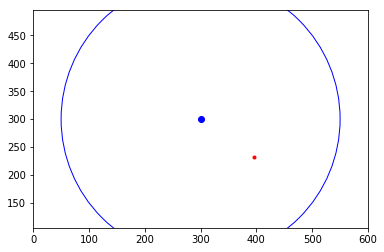

In [7]:
# Round 0: create network area, place base station and clients
num_clients = 3
simulation_time = 10
x_area = 600
y_area = 600

bs = BaseStation(0, basestation.get('x'), basestation.get('y'), basestation.get('coverage'), basestation.get('capacity'), basestation.get('ratios'))

clients = []
for i in range(num_clients):
    x = r.randint(0, x_area)
    y = r.randint(0, y_area)
    freq = r.random()
    
    mobility_pattern = get_random_mobility_pattern(mb_weights, m_patterns)
    slice_type = get_random_slice_type(slice_weights) 
    slice_capacity = bs.ratios.get(slice_type) * bs.capacity
    
    c = Client(i, x, y, mobility_pattern, freq, slice_type, slice_capacity, bs, None)
    clients.append(c)

client_per_slice = get_number_user_slice_type(clients) # count total client per slice

ax = plt.gca()
plt.axis('equal')
ax.set_xlim(0, x_area)
ax.set_ylim(0, y_area)
ax.plot(bs.x, bs.y, 'o', color='blue')
circle = plt.Circle((bs.x,bs.y), radius = bs.coverage, fill=False, color='blue')
ax.add_artist(circle)
    
for i in range(num_clients):
    ax.plot(clients[i].x, clients[i].y,'.',color='red')

In [8]:
# Define class Request
class Request:
    def __init__(self, id_client, type_slice, traffic_request, traffic_left):
        self.id_client = id_client
        self.type_slice = type_slice
        self.traffic_request = traffic_request
        self.traffic_left = traffic_left

In [9]:
clients_inRange = []

for i in range(num_clients):
    if inRange(clients[i], bs):
        clients_inRange.append(clients[i])

# create fixed size list to manage the request
request_list = [None] * len(clients)
active_clients = []

for n in range(simulation_time):
    
    # manage number active clients
    active = []
    active = r.sample(clients_inRange, k=len(clients_inRange))
    for j in range(len(active)):
        if request_list[active[j].ID] == None:
            active_clients.append(active[j])      
    # else: --> add traffic to usage_rem????
        
    print('STEP', n)
    
    for i in range(len(active_clients)):   
        # step 1 and create request
        active_clients[i].step_1()
        
        req = Request(active_clients[i].ID, active_clients[i].slice_type, active_clients[i].usage_rem, active_clients[i].usage_rem)
        request_list[active_clients[i].ID] = req
    
    for i in range(len(active_clients)):
        # step 2 and update request (delete non active user, and update traffic)
        active_clients[i].step_2()
        
        if active_clients[i].connected == False:
            request_list[active_clients[i].ID] = None
        else:
            request_list[active_clients[i].ID].traffic_left = active_clients[i].usage_rem
    
    for item in active_clients:
        # step 3 and delete also user not in range
        item.step_3()
        if item.connected == False:
            request_list[item.ID] = None
            active_clients.remove(item)

STEP 0
Client 2, coordinates : (395, 232) connected to slice mMTC @ BS0
Client_2, coordinates : (395, 232) requests 243986923 usage to BS0
STEP 1
Client 2, coordinates: (394.951389805783, 231.94929498574555) gets 100000000 usage from @ BS0
Client 2, coordinates: (394.951389805783, 231.94929498574555), releases 100000000 usage to BS0
STEP 2
Client 2, coordinates: (394.8328104959141, 231.89738966547864) gets 100000000 usage from @ BS0
Client 2, coordinates: (394.8328104959141, 231.89738966547864), releases 100000000 usage to BS0
STEP 3
Client 2, coordinates: (394.9432127800738, 232.00911536557683) gets 43986923 usage from @ BS0
Client 2, coordinates: (394.9432127800738, 232.00911536557683), releases 43986923 usage to BS0
Client 2, coordinates: (394.9432127800738,232.00911536557683) disconnected from slice mMTC @ BS0 
STEP 4
Client 2, coordinates : (395.0064242659768, 232.05666126913758) connected to slice mMTC @ BS0
Client_2, coordinates : (395.0064242659768, 232.05666126913758) requests